In this notebook, I trained and customized zero-shot classification model using our data. I randomly selected 100 transcripts and gave label to each sentences such as 'self-determined', 'dependent',  and 'neutral'. At the end of the notebook, I evaluated the model and showed the confusion matrix.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install datasets

     |████████████████████████████████| 325 kB 28.8 MB/s 
     |████████████████████████████████| 1.1 MB 6.6 MB/s 
     |████████████████████████████████| 212 kB 10.3 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 136 kB 29.2 MB/s 
     |████████████████████████████████| 127 kB 35.1 MB/s 
     |████████████████████████████████| 144 kB 60.9 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 57.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
! pip install transformers

     |████████████████████████████████| 4.0 MB 33.3 MB/s 
     |████████████████████████████████| 880 kB 64.5 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 596 kB 59.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=7545eb770a55e32a92d1542950cef6b97d723fdc098adc882af0022d92a91b83
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
# data access and processing
import pandas as pd
import numpy as np

# File helpers
import glob
import warnings

# python helpers
import os.path
import re

import seaborn as sns
from datasets import load_dataset, load_metric, Dataset

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, classification_report
import torch

import os

from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
base_prefix = '/content/drive/MyDrive/Capstone Design/data/zero_shot'

In [6]:
# get filenames list
filenames = glob.glob(base_prefix + '/*.xlsx')

In [7]:
len(filenames)

70

In [40]:
df = pd.read_excel(filenames[0])

In [41]:
df.shape[0]

(169, 6)

In [42]:
count = 0
for i in range(len(filenames)):
  df = pd.read_excel(filenames[0])
  temp = df.shape[0]
  count += temp

In [43]:
count

11830

In [8]:
self_num = []
self_pro = []
for data in range(len(filenames)):
  df = pd.read_excel(filenames[data])
  all = df.shape[0]
  temp = df[~df['Self-Determination'].isna()]
  self_determin = temp.shape[0]
  self_num.append(self_determin)
  proportion = self_determin/all * 100
  self_pro.append(proportion)

In [9]:
self_speech = []
for data in range(len(filenames)):
  df = pd.read_excel(filenames[data])
  temp = df[~df['Self-Determination'].isna()]
  if temp.shape[0] != 0:
    self_speech.append(temp)

In [10]:
len(self_speech)

54

In [11]:
self_speech[25]

,Unnamed: 0,speech,Educational Participation,Vocational Participation,Support,Self-Determination
198,198,He chose to leave the program and you said it ...,NaN,NaN,NaN,y
202,202,"He said ""I don't want to be in that environmen...",NaN,NaN,NaN,y
217,217,How long was he there? Just eight weeks and I ...,y,NaN,NaN,y


In [38]:
self_speech

[     Unnamed: 0                                             speech  \
 11           11               But that really hurt her self-esteem   
 17           17  How did she find that job? Just by going to th...   
 84           84  And because I thought I'm going to let Chloe b...   
 90           90  So she failed it and that really hurt her self...   
 123         123  I like that they mandate the tutoring and the ...   
 193         193          She has pretty poor self esteem right now   
 
     Educational Participation Vocational Participation Support  \
 11                        NaN                      NaN     NaN   
 17                        NaN                        y     NaN   
 84                        NaN                      NaN     NaN   
 90                        NaN                      NaN     NaN   
 123                       NaN                      NaN     NaN   
 193                       NaN                      NaN     NaN   
 
     Self-Determination  
 11 

In [12]:
frames = [self_speech[0], self_speech[1], self_speech[2], self_speech[3], self_speech[4], self_speech[5],self_speech[6], self_speech[7], self_speech[8], self_speech[9], self_speech[10], self_speech[11],self_speech[12], self_speech[13], self_speech[14], self_speech[15], self_speech[16], self_speech[17],self_speech[18], self_speech[19], self_speech[20], self_speech[21], self_speech[22], self_speech[23],self_speech[24], self_speech[25], self_speech[26], self_speech[27], self_speech[28], self_speech[29],self_speech[30], self_speech[31], self_speech[32], self_speech[33], self_speech[34], self_speech[35],self_speech[36], self_speech[37], self_speech[38],self_speech[39], self_speech[40], self_speech[41], self_speech[42], self_speech[43], self_speech[44],self_speech[45], self_speech[46], self_speech[47], self_speech[48],self_speech[49], self_speech[50], self_speech[51], self_speech[52],self_speech[53]]

In [13]:
final_self_df = pd.concat(frames)

In [14]:
final_self_df.tail()

,Unnamed: 0,speech,Educational Participation,Vocational Participation,Support,Self-Determination
47,47,"And he follows a routine on his own, gets hims...",NaN,NaN,NaN,y
49,49,Like he is 100% independent about managing his...,NaN,NaN,NaN,y
54,54,And just other things like he brings his laund...,NaN,NaN,NaN,y
55,55,And yesterday he came downstairs and the dishw...,NaN,NaN,NaN,y
42,42,And how did she find this job? She sought a job,NaN,NaN,NaN,y


In [45]:
final_self_df[final_self_df['label'] == 'dependent']

,speech,label
11,But that really hurt her self-esteem,dependent
90,So she failed it and that really hurt her self...,dependent
123,I like that they mandate the tutoring and the ...,dependent
193,She has pretty poor self esteem right now,dependent
27,"At that point, I was like, I want my daughter ...",dependent
...,...,...
12,And this is just something that we ask to ever...,dependent
14,He won't get online with me or he just won't f...,dependent
15,"He wants it to be done, but he won't take the ...",dependent
22,"How did he find this job? Oh, we were just app...",dependent


In [15]:
final_self_df = final_self_df[["speech", "Self-Determination"]]

In [16]:
final_self_df = final_self_df.rename({'Self-Determination': 'label'}, axis = 1)

In [17]:
final_self_df.loc[(final_self_df.label == 'n'),'label']='dependent'
final_self_df.loc[(final_self_df.label == 'y'),'label']='self-determined'

In [18]:
final_self_df

,speech,label
11,But that really hurt her self-esteem,dependent
17,How did she find that job? Just by going to th...,self-determined
84,And because I thought I'm going to let Chloe b...,self-determined
90,So she failed it and that really hurt her self...,dependent
123,I like that they mandate the tutoring and the ...,dependent
...,...,...
47,"And he follows a routine on his own, gets hims...",self-determined
49,Like he is 100% independent about managing his...,self-determined
54,And just other things like he brings his laund...,self-determined
55,And yesterday he came downstairs and the dishw...,self-determined


In [19]:
self_yes = final_self_df[final_self_df['label'] == 'self-determined']
self_no = final_self_df[final_self_df['label'] == 'dependent']

In [20]:
self_yes.shape[0]

151

In [21]:
self_no.shape[0]

84

In [22]:
self_no_speech = []
for data in range(len(filenames)):
  df = pd.read_excel(filenames[data])
  temp = df[df['Self-Determination'].isna()]
  if temp.shape[0] != 0:
    self_no_speech.append(temp)

In [23]:
len(self_no_speech)

70

In [24]:
frames = [self_no_speech[0], self_no_speech[1], self_no_speech[2], self_no_speech[3], self_no_speech[4], self_no_speech[5],self_no_speech[6], self_no_speech[7], self_no_speech[8], self_no_speech[9], self_no_speech[10], self_no_speech[11],self_no_speech[12], self_no_speech[13], self_no_speech[14], self_no_speech[15], self_no_speech[16], self_no_speech[17],self_no_speech[18], self_no_speech[19], self_no_speech[20], self_no_speech[21], self_no_speech[22], self_no_speech[23],self_no_speech[24], self_no_speech[25], self_no_speech[26], self_no_speech[27], self_no_speech[28], self_no_speech[29],self_no_speech[30], self_no_speech[31], self_no_speech[32], self_no_speech[33], self_no_speech[34], self_no_speech[35], self_no_speech[36], self_no_speech[37], self_no_speech[38],self_no_speech[39], self_no_speech[40], self_no_speech[41], self_no_speech[42], self_no_speech[43], self_no_speech[44],self_no_speech[45], self_no_speech[46], self_no_speech[47], self_no_speech[48], self_no_speech[49], self_no_speech[50], self_no_speech[51], self_no_speech[52],self_no_speech[53], self_no_speech[54], self_no_speech[55], self_no_speech[56], self_no_speech[57], self_no_speech[58],self_no_speech[59], self_no_speech[60], self_no_speech[61], self_no_speech[62], self_no_speech[63], self_no_speech[64],self_no_speech[65], self_no_speech[66], self_no_speech[67], self_no_speech[68], self_no_speech[69]]

In [25]:
final_self_no_df = pd.concat(frames)

In [26]:
final_self_no_df = final_self_no_df.reset_index(drop = True)

In [27]:
final_self_no_df

,Unnamed: 0,speech,Educational Participation,Vocational Participation,Support,Self-Determination
0,0,And so just confirming that she graduated high...,y,NaN,NaN,NaN
1,1,But what year and month do you remember her gr...,NaN,NaN,NaN,NaN
2,2,"Let's see, we moved here in '13..",NaN,NaN,NaN,NaN
3,3,"Ah boy, let me think",NaN,NaN,NaN,NaN
4,4,"She, I think she graduated..",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
14217,97,And there's something that's familiar with,NaN,NaN,NaN,NaN
14218,98,Great,NaN,NaN,NaN,NaN
14219,99,"And, Okay",NaN,NaN,NaN,NaN
14220,100,And so now we'll switch gears one more time to...,NaN,NaN,NaN,NaN


In [28]:
final_no_self_df = final_self_no_df.sample(n = final_self_df.shape[0])

In [29]:
final_no_self_df.head()

,Unnamed: 0,speech,Educational Participation,Vocational Participation,Support,Self-Determination
9230,372,Got it,NaN,NaN,NaN,NaN
7814,37,This only between last time you spoke and then...,NaN,NaN,NaN,NaN
4316,72,How did you feel about that one? Was that a go...,NaN,NaN,NaN,NaN
12867,19,And do you think that job is a good fit with A...,NaN,NaN,NaN,NaN
122,122,"So she thought for a while, and she said, ""wel...",NaN,NaN,NaN,NaN


In [30]:
final_no_self_df = final_no_self_df[['speech', 'Self-Determination']]

In [31]:
final_no_self_df = final_no_self_df.fillna('neutral')

In [32]:
final_no_self_df

,speech,Self-Determination
9230,Got it,neutral
7814,This only between last time you spoke and then...,neutral
4316,How did you feel about that one? Was that a go...,neutral
12867,And do you think that job is a good fit with A...,neutral
122,"So she thought for a while, and she said, ""wel...",neutral
...,...,...
13402,I have a student that works four hours a day a...,neutral
4095,"I, we had a little pass to get in case we got ...",neutral
10727,"A half a second was ambitious, but okay",neutral
9391,And did he receive support while he was workin...,neutral


In [33]:
final_no_self_df = final_no_self_df.rename({'Self-Determination': 'label'}, axis = 1)

In [34]:
final_no_self_df

,speech,label
9230,Got it,neutral
7814,This only between last time you spoke and then...,neutral
4316,How did you feel about that one? Was that a go...,neutral
12867,And do you think that job is a good fit with A...,neutral
122,"So she thought for a while, and she said, ""wel...",neutral
...,...,...
13402,I have a student that works four hours a day a...,neutral
4095,"I, we had a little pass to get in case we got ...",neutral
10727,"A half a second was ambitious, but okay",neutral
9391,And did he receive support while he was workin...,neutral


In [35]:
merge_df = pd.concat([final_self_df, final_no_self_df])

In [36]:
merge_df = merge_df.reset_index(drop = True)

In [37]:
data = merge_df
data.head()

,speech,label
0,But that really hurt her self-esteem,dependent
1,How did she find that job? Just by going to th...,self-determined
2,And because I thought I'm going to let Chloe b...,self-determined
3,So she failed it and that really hurt her self...,dependent
4,I like that they mandate the tutoring and the ...,dependent


In [ ]:
data.shape

(470, 2)

In [ ]:
# Add column 'label_digit' to convert classes' type into numbers.
conditions = [
    (data['label'] == "dependent"),
    (data['label'] == 'self-determined'),
    (data['label'] == 'neutral')
    ]

values = [0, 1, 2]

data['label_digit'] = np.select(conditions, values)

In [ ]:
data

,speech,label,label_digit
0,But that really hurt her self-esteem,dependent,0
1,How did she find that job? Just by going to th...,self-determined,1
2,And because I thought I'm going to let Chloe b...,self-determined,1
3,So she failed it and that really hurt her self...,dependent,0
4,I like that they mandate the tutoring and the ...,dependent,0
...,...,...,...
465,I'm ready to ask..,neutral,2
466,Yeah,neutral,2
467,But I think manual labor is something that is ...,neutral,2
468,And did she receive any supports while working...,neutral,2


# Load tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/bert-base-cased/resolve/main/voc

In [ ]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(data, test_size=0.2, random_state=2)

In [ ]:
testing_data[testing_data['label'] == 'dependent']

,speech,label,label_digit
200,"So she was waiting, like you were talking abou...",dependent,0
20,So I just think that it was just the wrong fit...,dependent,0
141,"You've got it, mom."" But then he doesn't actua...",dependent,0
18,He wanted to be a baker,dependent,0
160,"And of the three majors, Tony and I always fel...",dependent,0
84,"And if she wanted extra help, she could have g...",dependent,0
175,"Oh, first, can you tell me, how did he find th...",dependent,0
214,Do you know what his projected exit date is in...,dependent,0
216,They're a go between for him instructors to ma...,dependent,0
65,"But once you push her into it, then she does i...",dependent,0


In [ ]:
training_data[training_data['label'] == 'dependent']

,speech,label,label_digit
117,"And I found it and I'm like, ""I don't know if ...",dependent,0
170,And so when I was asking them about employment...,dependent,0
198,"If you ask him, he won't understand what you'r...",dependent,0
203,And so we're allowing him to continue going,dependent,0
222,We were just walking in,dependent,0
...,...,...,...
116,So I was looking for delivery drivers and just...,dependent,0
218,And this is just something that we ask to ever...,dependent,0
213,"And I don't want a situation to arise, you kno...",dependent,0
22,She wanted to get straight into Vanderbilt and...,dependent,0


In [ ]:
#create tokenized representations
train_text = training_data['speech'].tolist()
test_text = testing_data['speech'].tolist()

train_encodings = tokenizer(train_text, truncation=True, padding='longest')
test_encodings = tokenizer(test_text, truncation=True, padding='longest')

In [ ]:
#helpers for class size and class names
no_classes = len(training_data['label_digit'].unique())
label_dict = {0:"dependent", 1:'self-determined', 2:'neutral'}
train_classes = [label_dict[class_ind] for class_ind in range(no_classes)]
formal_labels = ["dependent", 'self-determined', "neutral"]
rev_labels_lookup = dict(zip(train_classes, formal_labels))

In [ ]:
training_data['label_digit'].unique()

array([0, 1, 2])

In [ ]:
print(no_classes)
print(label_dict)
print(train_classes)
print(formal_labels)
print(rev_labels_lookup)

3
{0: 'dependent', 1: 'self-determined', 2: 'neutral'}
['dependent', 'self-determined', 'neutral']
['dependent', 'self-determined', 'neutral']
{'dependent': 'dependent', 'self-determined': 'self-determined', 'neutral': 'neutral'}


In [ ]:
#Create custom Datasets Class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#Create datasets from encodings
train_dataset = CustomDataset(train_encodings, training_data['label_digit'].tolist())
test_dataset = CustomDataset(test_encodings, testing_data['label_digit'].tolist())

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=no_classes, id2label=label_dict)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "dependent",
    "1": "self-determined",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transfo

# Train model

In [ ]:
training_args = TrainingArguments("test_trainer", num_train_epochs=5, logging_strategy='epoch')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 376
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 235


Step,Training Loss
47,0.906500
94,0.567000
141,0.217700
188,0.062500
235,0.007700




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=235, training_loss=0.3522694609266646, metrics={'train_runtime': 25.563, 'train_samples_per_second': 73.544, 'train_steps_per_second': 9.193, 'total_flos': 92747479749120.0, 'train_loss': 0.3522694609266646, 'epoch': 5.0})

In [ ]:
trainer.evaluate(train_dataset)

***** Running Evaluation *****
  Num examples = 376
  Batch size = 8


{'epoch': 5.0,
 'eval_accuracy': 1.0,
 'eval_loss': 0.002500900998711586,
 'eval_runtime': 1.3351,
 'eval_samples_per_second': 281.633,
 'eval_steps_per_second': 35.204}

In [ ]:
trainer.save_model('bert-teacher-saying-classifier')
teacher_classifier = pipeline('text-classification', model='bert-teacher-saying-classifier')

Saving model checkpoint to bert-teacher-saying-classifier
Configuration saved in bert-teacher-saying-classifier/config.json
Model weights saved in bert-teacher-saying-classifier/pytorch_model.bin
tokenizer config file saved in bert-teacher-saying-classifier/tokenizer_config.json
Special tokens file saved in bert-teacher-saying-classifier/special_tokens_map.json
loading configuration file bert-teacher-saying-classifier/config.json
Model config BertConfig {
  "_name_or_path": "bert-teacher-saying-classifier",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "dependent",
    "1": "self-determined",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-

In [ ]:
# Predict labels of validation dataset
test_pred = teacher_classifier(test_text)
# Convert list into dataframe
test_pred_df = pd.DataFrame(test_pred)
# Change the column's name (label -> predict)
test_pred_df.rename(columns = {'label':'predict'}, inplace = True)

In [ ]:
# Get the true label and speech
test_true = testing_data[["speech", "label"]]
test_true.reset_index(inplace = True, drop = True)

# Combine two dataframe
test_final_df = pd.concat([test_true, test_pred_df], axis = 1)
test_final_df.head()

,speech,label,predict,score
0,"So she was waiting, like you were talking abou...",dependent,dependent,0.534249
1,Just making sure,neutral,neutral,0.999083
2,He's doing a lot right now and he has great an...,self-determined,neutral,0.991476
3,He is in individualized home-based program,neutral,neutral,0.999008
4,It's just whether..,neutral,neutral,0.999153


In [ ]:
test_final_df[test_final_df['label'] == 'dependent']

,speech,label,predict,score
0,"So she was waiting, like you were talking abou...",dependent,dependent,0.534249
6,So I just think that it was just the wrong fit...,dependent,dependent,0.977341
11,"You've got it, mom."" But then he doesn't actua...",dependent,self-determined,0.859937
24,He wanted to be a baker,dependent,self-determined,0.997818
25,"And of the three majors, Tony and I always fel...",dependent,self-determined,0.751610
37,"And if she wanted extra help, she could have g...",dependent,self-determined,0.935229
40,"Oh, first, can you tell me, how did he find th...",dependent,dependent,0.990859
45,Do you know what his projected exit date is in...,dependent,dependent,0.993963
47,They're a go between for him instructors to ma...,dependent,dependent,0.955880
51,"But once you push her into it, then she does i...",dependent,self-determined,0.992646


In [ ]:
c_ma = confusion_matrix(test_final_df['label'], test_final_df['predict'], labels = train_classes)

In [ ]:
c_df = pd.DataFrame(c_ma,
                    columns = train_classes,
                    index = train_classes)

#use reverse lookup table from above to use the actual labels that we assigned for zero shot
c_df.rename(columns=rev_labels_lookup, index=rev_labels_lookup, inplace=True)

#add axis labels for seaborn
c_df.index.name = 'Actual Labels'
c_df.columns.name = 'Predicted Labels'

#inspect
c_df

Predicted Labels,dependent,self-determined,neutral
Actual Labels,,,
dependent,8,6,4
self-determined,9,19,6
neutral,4,5,33


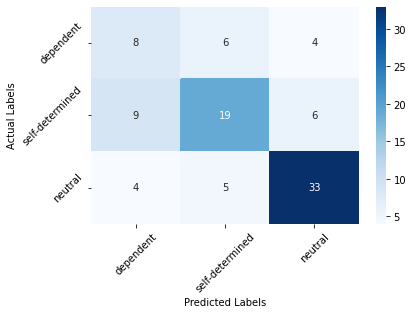

In [ ]:
#use seaborne to display as heatmap
ax = sns.heatmap(c_df, cmap='Blues', annot=True, fmt='d');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);
ax.set_yticklabels(ax.get_yticklabels(),rotation = 45);

In [ ]:
#text = ['I started to work for Vanderbilt University because my mom asked me to do that', 'I got help from the agency']
#test_encodings = tokenizer(test_text, truncation=True, padding='longest')

In [ ]:
test_pred = teacher_classifier(test_text)

In [ ]:
test_pred

[{'label': 'dependent', 'score': 0.5342487096786499},
 {'label': 'neutral', 'score': 0.9990832805633545},
 {'label': 'neutral', 'score': 0.9914758205413818},
 {'label': 'neutral', 'score': 0.9990084767341614},
 {'label': 'neutral', 'score': 0.9991532564163208},
 {'label': 'self-determined', 'score': 0.9967706203460693},
 {'label': 'dependent', 'score': 0.9773409366607666},
 {'label': 'self-determined', 'score': 0.9985448122024536},
 {'label': 'self-determined', 'score': 0.997944176197052},
 {'label': 'neutral', 'score': 0.9991471767425537},
 {'label': 'dependent', 'score': 0.8229873776435852},
 {'label': 'self-determined', 'score': 0.859936535358429},
 {'label': 'neutral', 'score': 0.9985552430152893},
 {'label': 'neutral', 'score': 0.9992401599884033},
 {'label': 'neutral', 'score': 0.9990226030349731},
 {'label': 'neutral', 'score': 0.823267936706543},
 {'label': 'neutral', 'score': 0.999207079410553},
 {'label': 'self-determined', 'score': 0.9987530708312988},
 {'label': 'self-deter

In [ ]:
test_final_df[test_final_df['label'] != test_final_df['predict']]

,speech,label,predict,score
2,He's doing a lot right now and he has great an...,self-determined,neutral,0.991476
10,And then was I parish that was even a shorter ...,self-determined,dependent,0.822987
11,"You've got it, mom."" But then he doesn't actua...",dependent,self-determined,0.859937
12,"But he's resourceful when he wants to be, but ...",self-determined,neutral,0.998555
15,"And I said, how are you going to get to Madiso...",self-determined,neutral,0.823268
23,He just never really walked through what Excel...,neutral,self-determined,0.907568
24,He wanted to be a baker,dependent,self-determined,0.997818
25,"And of the three majors, Tony and I always fel...",dependent,self-determined,0.751610
30,Like he is 100% independent about managing his...,self-determined,dependent,0.874695
32,But I think manual labor is something that is ...,neutral,dependent,0.982339


In [ ]:
perf_metrics = classification_report(test_final_df.dropna()['label'], test_final_df.dropna()['predict'], labels=train_classes, target_names = formal_labels)
print(perf_metrics)

                 precision    recall  f1-score   support

      dependent       0.38      0.44      0.41        18
self-determined       0.63      0.56      0.59        34
        neutral       0.77      0.79      0.78        42

       accuracy                           0.64        94
      macro avg       0.59      0.60      0.59        94
   weighted avg       0.64      0.64      0.64        94



# Why accuracy is low?